# Dataset

In [ ]:
import pandas as pd
import numpy as np
import cv2
from keras.utils import Sequence
from matplotlib.pyplot import imshow
import os

In [ ]:
!pip install remotezip tqdm opencv-python einops imageio
!pip install -U tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 44.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class_labels = ['Squats', 'Lunges', 'PushUps']

root_path = '/content/drive/MyDrive/3RD YR. - 2ND SEM./CPE 313/Final Project/'
# root_path = '/content/drive/MyDrive/'
data_path = root_path + "dataset/ucf101/"

HEIGHT = 244
WIDTH = 244
FRAMES = 15

In [ ]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

import random
from pathlib import Path

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir, selected_classes):
    """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.
      selected_classes: List of selected classes to download.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
    """
    random.seed(191919)

    # Retrieve file list and organize them by class
    files = list_files_per_class(zip_url)
    for f in files:
        tokens = f.split('/')
        if len(tokens) <= 2:
            files.remove(f)  # Remove items without filenames

    files_for_class = get_files_per_class(files)

    # Filter classes based on selected_classes
    classes = [cls for cls in selected_classes if cls in files_for_class.keys()]

    # Shuffle files for each selected class
    for cls in classes:
        new_files_for_class = files_for_class[cls]
        random.shuffle(new_files_for_class)
        files_for_class[cls] = new_files_for_class

    # Keep only the number of classes specified
    files_for_class = {cls: files_for_class[cls] for cls in classes[:num_classes]}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = Path(download_dir) / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir

    return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (WIDTH, HEIGHT), frame_step = 5):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.
33333
    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
!pip install imgaug

In [ ]:
import imgaug.augmenters as iaa
import random
from pathlib import Path

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        self.path = Path(path)
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

        self.generate_augmentor()

    def generate_augmentor(self):
      # Define augmentation pipeline for video frames
        sequence = []

        if random.random() < 0.5:
          sequence.append(iaa.Fliplr(1))

        if random.random() < 0.5:
          sequence.append(iaa.Affine(rotate=45))

        if random.random() < 0.5:
          sequence.append(iaa.GaussianBlur(sigma=(1, 2)))

        if random.random() < 0.5:
          sequence.append(iaa.Sharpen(alpha=(0, 1)))

        self.augmentor = iaa.Sequential(sequence)

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def augment_video_frames(self, video_frames):
        if self.training:
            augmented_frames = self.augmentor(images=video_frames)
            return augmented_frames
        else:
            return video_frames

    def __call__(self):
        self.generate_augmentor()
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            # Read video frames from the video file
            frame_step = random.randint(3, 8)
            video_frames = frames_from_video_file(path, self.n_frames, frame_step=frame_step)
            video_frames_aug = self.augment_video_frames(video_frames)
            label = self.class_ids_for_name[name]  # Encode labels
            yield video_frames_aug, label

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 3,
                        splits = {"train": 35, "val": 15, "test": 5},
                        download_dir = download_dir,
                    selected_classes = ['BodyWeightSquats', 'Lunges', 'PushUps'])

train :


100%|██████████| 105/105 [00:33<00:00,  3.10it/s]


val :


100%|██████████| 45/45 [00:07<00:00,  6.10it/s]


test :


100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


In [ ]:
n_frames = 15
batch_size = 10

output_signature = (tf.TensorSpec(shape = (FRAMES, WIDTH, HEIGHT, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

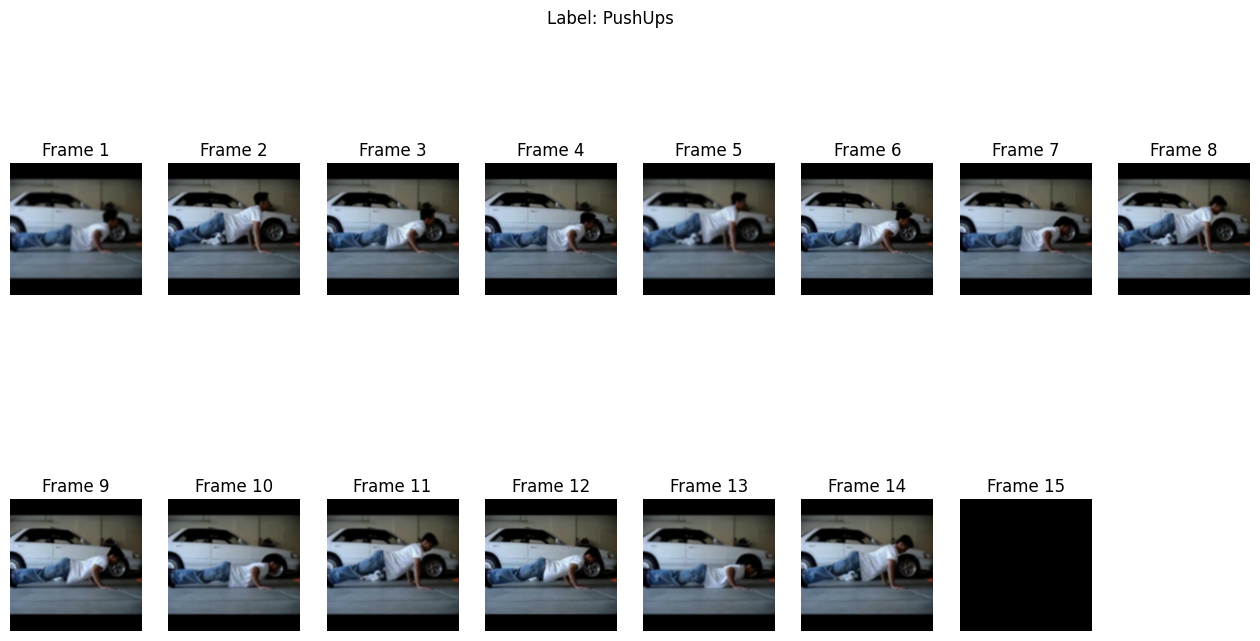

In [ ]:
def plot_frames(frames, label):
    plt.figure(figsize=(16, 8))
    for i in range(len(frames)):
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(frames[i].astype("float32"))
        plt.title(f"Frame {i+1}")
        plt.axis("off")
    plt.suptitle(f"Label: {class_labels[label]}")
    plt.show()

for frames_batch, labels_batch in train_ds.take(40):
    frames = frames_batch[7].numpy()  # Convert the tensor to numpy array
    label = labels_batch[7].numpy()  # Convert the tensor to numpy array
    plot_frames(frames, label)
    break

# Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential

In [ ]:
def build_3d_cnn(input_shape=(FRAMES, WIDTH, HEIGHT, 3)):
    model = Sequential()

    # First Conv Block
    model.add(layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
    model.add(layers.Dropout(0.25))

    # Second Conv Block
    model.add(layers.Conv3D(128, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(layers.Dropout(0.25))

    # Third Conv Block
    model.add(layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(layers.Dropout(0.25))

    # Fourth Conv Block
    model.add(layers.Conv3D(512, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.Conv3D(512, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3))

    return model

In [ ]:
model = build_3d_cnn()
model.compile(optimizer='adam', loss='sparsecategorical_entropy')

model.summary(expand_nested=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 15, 244, 244, 64)    │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 122, 122, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 122, 122, 64)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 122, 122, 128)   │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 61, 61, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 61, 61, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 61, 61, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 7, 61, 61, 256)      │       1,769,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 3, 30, 30, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 30, 30, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 3, 30, 30, 512)      │       3,539,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 3, 30, 30, 512)      │       7,078,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 15, 15, 512)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 15, 15, 512)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     235,931,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,481,411 (955.51 MB)

 Trainable params: 250,481,411 (955.51 MB)

 Non-trainable params: 0 (0.00 B)

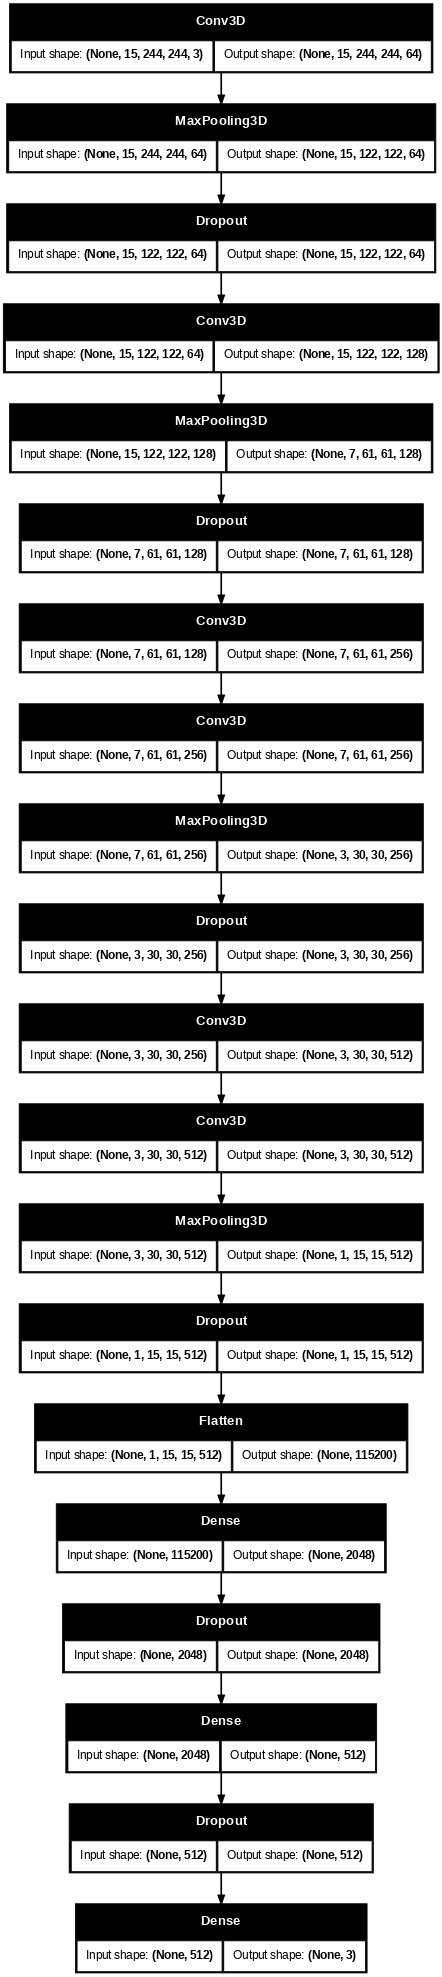

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.00001),
              metrics = ['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-8,
    verbose=1
)

In [ ]:
epochs = 100

history = model.fit(x = train_ds,
                    epochs = epochs,
                    validation_data = val_ds
                    )

Epoch 1/100
     11/Unknown 216s 10s/step - accuracy: 0.4666 - loss: 1.0921

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 237s 13s/step - accuracy: 0.4579 - loss: 1.0928 - val_accuracy: 0.3778 - val_loss: 1.0935
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - accuracy: 0.3475 - loss: 1.1047 - val_accuracy: 0.4889 - val_loss: 1.0929
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.3506 - loss: 1.1094 - val_accuracy: 0.4222 - val_loss: 1.0911
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.3820 - loss: 1.0794 - val_accuracy: 0.3556 - val_loss: 1.0891
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.3533 - loss: 1.0750 - val_accuracy: 0.5333 - val_loss: 1.0876
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.5141 - loss: 1.0540 - val_accuracy: 0.5111 - val_loss: 1.0852
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.4924 - loss: 1.0259 - val_accuracy: 0.4889 - val_loss: 1.0856
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.4562 - loss: 1.0927 - val_accuracy: 0.4444 - val_loss: 1

In [ ]:
np.save(root_path + f'models/3DCNN_1', history.history)
model.save(root_path + 'models/3DCNN.keras')

In [ ]:
epochs = 100

history = model.fit(x = train_ds,
                    epochs = epochs,
                    validation_data = val_ds)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.6082 - loss: 0.8866 - val_accuracy: 0.6000 - val_loss: 0.9761
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7108 - loss: 0.7937 - val_accuracy: 0.5333 - val_loss: 0.9663
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7082 - loss: 0.7510 - val_accuracy: 0.5556 - val_loss: 1.0607
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.7131 - loss: 0.7864 - val_accuracy: 0.4444 - val_loss: 1.0357
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7304 - loss: 0.7653 - val_accuracy: 0.5556 - val_loss: 1.0128
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.5970 - loss: 0.8801 - val_accuracy: 0.5333 - val_loss: 1.0289
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7000 - loss: 0.7709 - val_accuracy: 0.5333 - val_loss: 1.0024
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.7535 - loss: 0.7065 - val_accuracy: 0.5333 - v

In [ ]:
np.save(root_path + f'models/3DCNN_2', history.history)
model.save(root_path + 'models/3DCNN.keras')

# Model Metrics

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
metrics1 = np.load(root_path + 'models/3DCNN_1.npy', allow_pickle=True)
metrics1 = metrics1.all()
metrics2 = np.load(root_path + 'models/3DCNN_2.npy', allow_pickle=True)
metrics2 = metrics2.all()

combined_dict = {}

for key in metrics1:
        combined_dict[key] = metrics1[key] + metrics2[key]

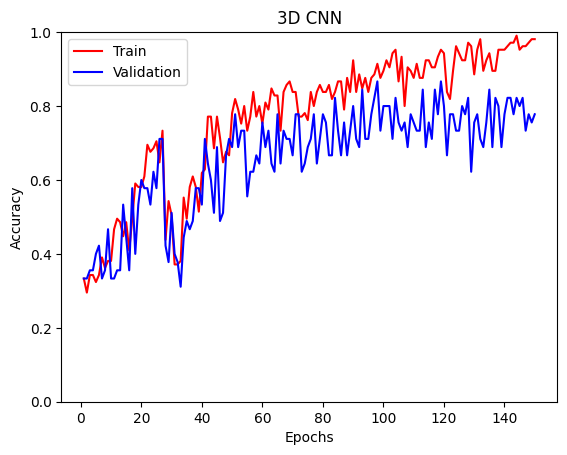

In [7]:
acc_list = combined_dict['accuracy']
val_acc_list = combined_dict['val_accuracy']

epochs = range(1, len(acc_list) + 1)
plt.plot(epochs, acc_list, 'r', label='Train')
plt.plot(epochs, val_acc_list, 'b', label='Validation')
plt.ylim(0, 1)
plt.title('3D CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

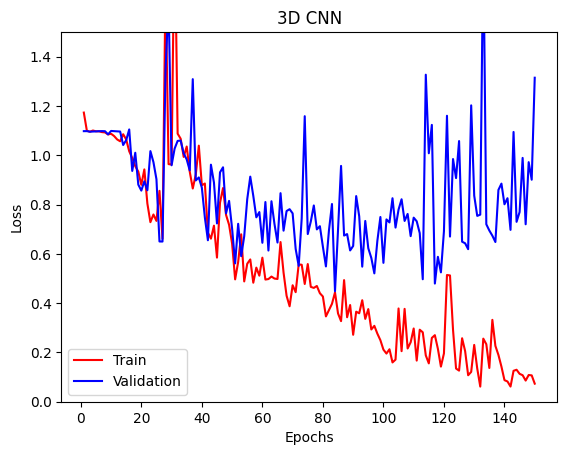

In [8]:
loss_list = combined_dict['loss']
val_loss_list = combined_dict['val_loss']

epochs = range(1, len(combined_dict['accuracy']) + 1)
plt.plot(epochs, loss_list, 'r', label='Train')
plt.plot(epochs, val_loss_list, 'b', label='Validation')
plt.title('3D CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.show()

In [9]:
print('training Accuracy:', max(acc_list))
print('validation Accuracy:', max(val_acc_list))
print('')
print('training Loss:', min(loss_list))
print('validation Loss:', min(val_loss_list))

training Accuracy: 0.9904761910438538
validation Accuracy: 0.8666666746139526

training Loss: 0.06143922731280327
validation Loss: 0.44840312004089355


# Model Evaluation

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import imageio
from tensorflow.keras.models import load_model

In [ ]:
# Load the pre-trained model (replace with the actual model you're using)
# For example, let's assume we have a model saved as 'action_recognition_model.h5'
model = load_model(root_path + 'models/3DCNN-LSTM.keras')

ValueError: File not found: filepath=/content/drive/MyDrive/models/3DCNN-LSTM.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
def recognize_action(frames, model):
    # Preprocess the frames for the model (resize, normalize, etc.)
    resized_frames = np.array([cv2.resize(frame, (WIDTH, HEIGHT)) for frame in frames])  # Resize to match model input size
    normalized_frames = resized_frames / 255.0  # Normalize pixel values
    input_frames = np.expand_dims(normalized_frames, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(input_frames)
    predicted_class = np.argmax(predictions, axis=1)[0]
    print(predictions)

    return class_labels[predicted_class] + f'({predictions[0][predicted_class]:.2f})'

def annotate_frame(frame, text):
    annotated_frame = frame.copy()
    cv2.putText(annotated_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    return annotated_frame

def create_gif_from_video(video_path, output_gif_path, model):
    cap = cv2.VideoCapture(video_path)
    frames = []
    gif_frames = []
    sequence_length = 15
    step_counter = 0
    steps = 5

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if step_counter % steps == 0:
            frames.append(frame)

        # If we have enough frames for a sequence, perform action recognition
        if len(frames) == sequence_length:
            action_class = recognize_action(frames, model)

            # Annotate each frame in the sequence
            annotated_frames = [annotate_frame(f, action_class) for f in frames]
            frames = []  # Clear the frames list

            # Add annotated frames to the GIF frames list
            gif_frames.extend([cv2.cvtColor(af, cv2.COLOR_BGR2RGB) for af in annotated_frames])

    cap.release()

    # Save frames as a GIF
    imageio.mimsave(output_gif_path, gif_frames, fps=25)
    print(f"GIF saved to {output_gif_path}")

def combine_videos_sequentially(video_paths, output_path):
    # Capture all the input videos
    caps = [cv2.VideoCapture(video) for video in video_paths]

    # Get properties from the first video
    frame_width = int(caps[0].get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(caps[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = caps[0].get(cv2.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    for cap in caps:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)
        cap.release()  # Release each video capture object after reading

    out.release()
    cv2.destroyAllWindows()

In [ ]:
# @title ## Push Ups

# Path to the video file
video_path = '/content/UCF101_subset/train/PushUps/v_PushUps_g01_c02.avi'

# Output path for the GIF
output_gif_path = root_path + 'metrics/3DCNN_PushUps.gif'

# Create the GIF from the video
create_gif_from_video(video_path, output_gif_path, model)

In [ ]:
# @title ## Squats

# Path to the video file
video_path = '/content/UCF101_subset/test/BodyWeightSquats/v_BodyWeightSquats_g25_c04.avi'

# Output path for the GIF
output_gif_path = root_path + 'metrics/3DCNN-LSTM_Squats.gif'

# Create the GIF from the video
create_gif_from_video(video_path, output_gif_path, model)

In [ ]:
# @title ## Lunges

# Path to the video file
video_path = '/content/UCF101_subset/test/Lunges/v_Lunges_g10_c03.avi'

# Output path for the GIF
output_gif_path = root_path + 'metrics/3DCNN-LSTM_Lunges.gif'

# Create the GIF from the video
create_gif_from_video(video_path, output_gif_path, model)

Google Colab Link: https://colab.research.google.com/drive/14HXr0CGgIICmfMloPG4mJXp0eWeM59rC?usp=sharing